In [1]:
print("Shree")

Shree


In [16]:
pip install spacy

In [47]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 576.5 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
pip install gensim

In [3]:
import gensim.downloader as api

In [4]:
wv=api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [5]:
import pandas as pd
import numpy as np

In [27]:
df = pd.read_csv('IFND.csv', encoding='latin1')

In [28]:
df=df.drop(columns=["Image","Web","Category","Date","id"])

In [31]:
df.Label.value_counts()

Label
TRUE    37800
Fake    18914
Name: count, dtype: int64

In [32]:
df.isna().sum()

Statement    0
Label        0
dtype: int64

In [38]:
df_true=df[df.Label=="TRUE"].sample(10000,random_state=1210)
df_false=df[df.Label=="Fake"].sample(10000,random_state=1210)

In [39]:
df_final=pd.concat([df_true,df_false])

In [40]:
df_final

,Statement,Label
11097,Coronavirus cases go past 1.25 lakh in Mumbai;...,TRUE
28945,"2 months before Lok Sabha polls, cracks in Har...",TRUE
13719,Coronavirus: Delhi L-G makes institutional qua...,TRUE
26566,Outside hand guiding LJP  Bihar BJP struggl...,TRUE
17471,National Covid recovery rate reaches 92.97 per...,TRUE
...,...,...
45784,300 sadhus in Jaipur tested positive for COVID...,Fake
44868,Fake supermoon Facebook live video gets 16 mil...,Fake
42719,"No, this video of an explosion is not from the...",Fake
39720,Is this bleeding JNU student injured by police...,Fake


In [42]:
df_final.Label.value_counts()

Label
TRUE    10000
Fake    10000
Name: count, dtype: int64

In [43]:
import spacy

In [48]:
nlp=spacy.load('en_core_web_lg')

In [63]:
def prepro_vect(text):
    doc=nlp(text)
    sent=[]
    for i in doc:
      if i.is_stop or i.is_punct:
        continue
      sent.append(i.lemma_)
      return wv.get_mean_vector(sent)

(300,)

In [66]:
df_final["vectors"]=df_final["Statement"].apply(prepro_vect)

In [82]:
df_final["Label"]=df_final["Label"].map({
    "TRUE":1,
    "Fake":0
})

In [101]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df_final["vectors"].values,df_final["Label"],test_size=0.2,random_state=1210,stratify=df_final["Label"])

In [102]:
X_train

array([array([-0.02474504,  0.03803404, -0.00263489,  0.09592521, -0.0482681 ,
               0.03360437,  0.02627251, -0.00836291, -0.00572802,  0.04643513,
              -0.0482681 , -0.04429667, -0.06781974,  0.03681206, -0.06445929,
               0.05621095,  0.13319552,  0.02230108,  0.06293183, -0.06140435,
               0.01550384,  0.01855878, -0.02932745,  0.06537578,  0.00530796,
               0.0043342 , -0.11608783, -0.00273036, -0.01092142, -0.01038681,
               0.03360437, -0.00588077, -0.12219772,  0.08370544, -0.03803404,
               0.02596701, -0.00817197,  0.10936696,  0.04032525,  0.08920433,
               0.1124219 , -0.0034559 ,  0.01603845,  0.02596701,  0.01664944,
              -0.05407249,  0.04674063,  0.0748461 ,  0.1771867 ,  0.06201534,
              -0.09409224,  0.05468348, -0.03543734, -0.08126149, -0.09714719,
              -0.00966126, -0.15519111, -0.09592521,  0.0242868 , -0.06812523,
               0.08614939,  0.04704612,  0.07179116,

In [103]:
y_train

54060    0
18586    1
46903    0
10325    1
51012    0
        ..
10836    1
38389    0
21024    1
11149    1
45558    0
Name: Label, Length: 16000, dtype: int64

In [104]:
X_train=np.stack(X_train)
X_test=np.stack(X_test)

In [105]:
X_train

array([[-0.02474504,  0.03803404, -0.00263489, ..., -0.12280871,
         0.0242868 ,  0.08492742],
       [ 0.03369883, -0.04479479, -0.01674668, ...,  0.05465786,
         0.05137017,  0.01869874],
       [ 0.06430785, -0.1344034 ,  0.0127008 , ...,  0.03569085,
         0.02491929,  0.11704028],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.03006368,  0.04568888,  0.03837075, ...,  0.01077941,
         0.07871936,  0.02828359],
       [-0.01958391,  0.1462673 , -0.06670768, ..., -0.13463935,
        -0.07894762, -0.00265836]], dtype=float32)

In [106]:
y_train.ndim

1

In [107]:
X_train.ndim

2

In [109]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor()

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(prepro_vect)

In [112]:
clf=Pipeline([
    ("vect",transformer),
    ("rf",RandomForestRegressor())
])

In [148]:
clf

Pipeline(steps=[('vect',
                 FunctionTransformer(func=<function prepro_vect at 0x7d5a20416b00>)),
                ('rf', RandomForestRegressor())])

In [167]:
import joblib
joblib.dump(clf,"clf_w2v.pkl")

['clf_w2v.pkl']

In [151]:
y_pred=rf.predict(X_test)

In [163]:
y_pred[:5]

array([0, 0, 0, 0, 0])

In [164]:
y_test[:5]

array([[0],
       [0],
       [1],
       [0],
       [0]])

In [165]:
accuracy_count=0.978134110787172
accuracy_tfidf=0.9686028257456829
accuracy3_w2v=0.9935698523488256

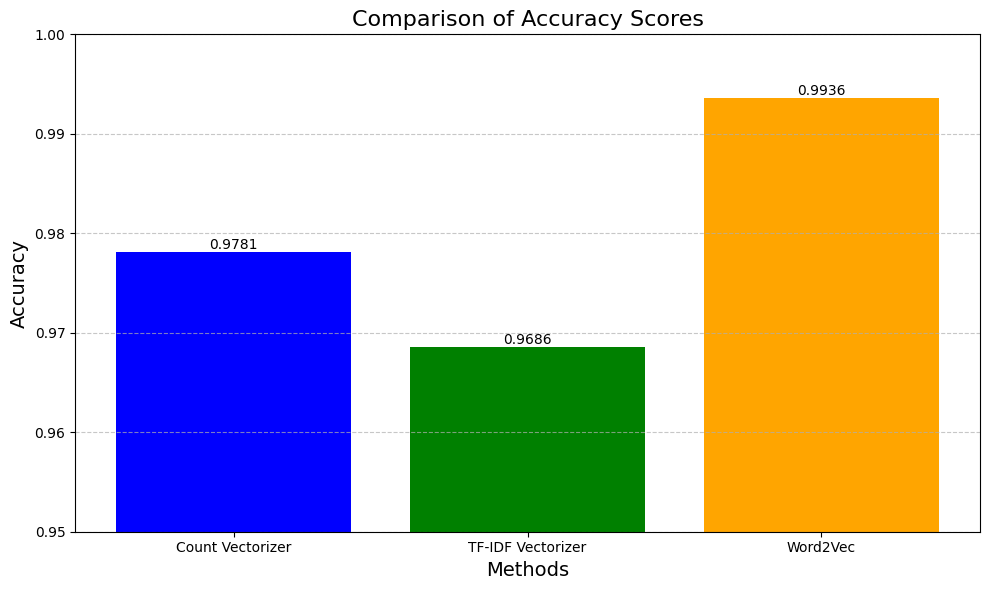

In [166]:
import matplotlib.pyplot as plt
methods = ['Count Vectorizer', 'TF-IDF Vectorizer', 'Word2Vec']
accuracy_scores = [0.978134110787172, 0.9686028257456829, 0.9935698523488256]
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, accuracy_scores, color=['blue', 'green', 'orange'])
for bar, score in zip(bars, accuracy_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(score, 4), ha='center', va='bottom', fontsize=10)

plt.title('Comparison of Accuracy Scores', fontsize=16)
plt.xlabel('Methods', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.95, 1.0)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
